# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/ctrpts'

EPOCHS = 10
BATCH_SIZE = 40

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

camera_data = np.load(f'../data/ctrlpts/camera_ctrlpt.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/ctrlpts/cell_phone_ctrlpt.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [3]:
from sklearn.model_selection import train_test_split

# Limiting data to 5000 points per class
def slice_data(data):
    # Assuming that the data arrays in each 'train', 'test', 'valid' are already shuffled
    sliced = []
    for key in ['train', 'test', 'valid']:
        # Slicing each segment
        sliced.append(data[key])
    # Concatenate slices from train, test, valid
    return np.concatenate(sliced)

# Slicing the data
camera_sliced = slice_data(camera_data)[:5000]
cellphone_sliced = slice_data(cellphone_data)[:5000]

# Concatenate all sliced data
def concatenate_data(*datasets):
    features = []
    labels = []
    for data, cid in zip(datasets, class_id.values()):
        features.append(data)
        labels.extend([cid] * len(data))
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

features, labels = concatenate_data(camera_sliced, cellphone_sliced)

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000,), (8000,), (2000,), (2000,))

In [5]:
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from scipy.interpolate import interp1d

def standardize_lengths(data, target_length=29):
    standardized_data = []

    for sequence in data:
        # Current length of the sequence
        current_length = sequence.shape[0]
        
        # Create an array of indices based on current length
        current_indices = np.linspace(0, 1, current_length)
        
        # Target indices for interpolation
        target_indices = np.linspace(0, 1, target_length)
        
        # Initialize interpolated sequence
        interpolated_sequence = np.zeros((target_length, sequence.shape[1]))
        
        # Interpolate each channel
        for i in range(sequence.shape[1]):
            # Interpolate the i-th channel
            interpolator = interp1d(current_indices, sequence[:, i], kind='linear')
            interpolated_sequence[:, i] = interpolator(target_indices)
        
        # Append the interpolated sequence to the standardized data list
        standardized_data.append(interpolated_sequence)

    return np.array(standardized_data)

# Apply standardization on X_train and X_test
X_train_standardized = standardize_lengths(X_train)
X_test_standardized = standardize_lengths(X_test)

def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train_standardized, X_test_standardized, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
print(len(train_loader))
print(len(test_loader))

200
50


In [7]:
X_train_standardized.shape, X_test_standardized.shape

((8000, 29, 3), (2000, 29, 3))

## 3. Model Building

### 3.1. Quantum Layer

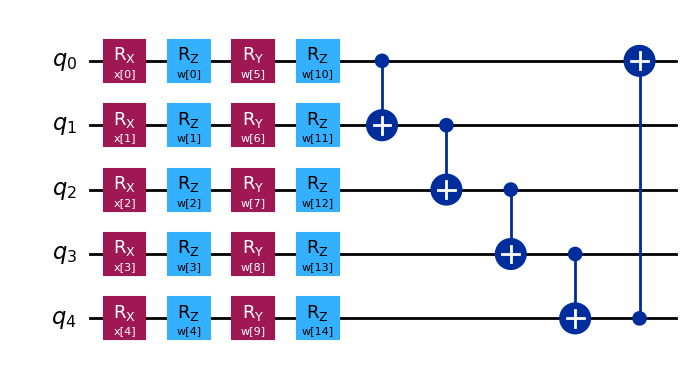

In [8]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        #self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        #self.bn1 = nn.BatchNorm1d(num_features=16)
        #self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        #self.bn2 = nn.BatchNorm1d(num_features=32)
        #self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        #self.bn3 = nn.BatchNorm1d(num_features=64)
        #self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        #self.bn4 = nn.BatchNorm1d(num_features=128)
        #self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(14, 14)
        self.fc2 = nn.Linear(14, 14)

        # Quantum layer
        self.fc3 = nn.Linear(14, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        #x = x.permute(0, 2, 1)

        # Convolutional layers
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool1(x)
        
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = self.pool2(x)
        
        #x = F.relu(self.bn3(self.conv3(x)))
        #x = self.pool3(x)
        
        #x = F.relu(self.bn4(self.conv4(x)))
        #x = self.pool4(x)

        # Reshape for LSTM
        #x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [10]:
checkpoint_filepath = 'models/2edition_quantum_lstm/best_model_weights_ctrlpts.pth'

In [11]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            
            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 200/200 [07:27<00:00,  2.24s/it]


Epoch 1, Accuracy: 0.6825, Loss: 0.6593404889106751, Validation Accuracy: 0.8425, Validation Loss: 0.6022645235061646


100%|██████████| 200/200 [08:48<00:00,  2.64s/it]


Epoch 2, Accuracy: 0.868, Loss: 0.5673045794665813, Validation Accuracy: 0.8855, Validation Loss: 0.5431175231933594


100%|██████████| 200/200 [07:38<00:00,  2.29s/it]


Epoch 3, Accuracy: 0.87625, Loss: 0.5282220397889614, Validation Accuracy: 0.8385, Validation Loss: 0.5125917792320251


100%|██████████| 200/200 [07:30<00:00,  2.25s/it]


Epoch 4, Accuracy: 0.888875, Loss: 0.4973177319765091, Validation Accuracy: 0.9, Validation Loss: 0.49409961700439453


100%|██████████| 200/200 [07:35<00:00,  2.28s/it]


Epoch 5, Accuracy: 0.9035, Loss: 0.4771517224609852, Validation Accuracy: 0.905, Validation Loss: 0.48926985263824463


100%|██████████| 200/200 [07:27<00:00,  2.24s/it]


Epoch 6, Accuracy: 0.913875, Loss: 0.45972491696476936, Validation Accuracy: 0.8895, Validation Loss: 0.4622404873371124


100%|██████████| 200/200 [07:28<00:00,  2.24s/it]


Epoch 7, Accuracy: 0.923125, Loss: 0.445899418592453, Validation Accuracy: 0.94, Validation Loss: 0.452058345079422


100%|██████████| 200/200 [07:37<00:00,  2.29s/it]


Epoch 8, Accuracy: 0.92975, Loss: 0.43714648380875587, Validation Accuracy: 0.935, Validation Loss: 0.4504297375679016


100%|██████████| 200/200 [07:21<00:00,  2.21s/it]


Epoch 9, Accuracy: 0.9315, Loss: 0.4279010207951069, Validation Accuracy: 0.9245, Validation Loss: 0.448393315076828


100%|██████████| 200/200 [07:18<00:00,  2.19s/it]


Epoch 10, Accuracy: 0.9335, Loss: 0.42409390896558763, Validation Accuracy: 0.9405, Validation Loss: 0.4411395192146301


100%|██████████| 200/200 [07:18<00:00,  2.19s/it]


Epoch 11, Accuracy: 0.93125, Loss: 0.42451187297701837, Validation Accuracy: 0.8345, Validation Loss: 0.4532514810562134


100%|██████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch 12, Accuracy: 0.93625, Loss: 0.41610655531287194, Validation Accuracy: 0.937, Validation Loss: 0.4337040185928345


100%|██████████| 200/200 [07:18<00:00,  2.19s/it]


Epoch 13, Accuracy: 0.95125, Loss: 0.4072492009401321, Validation Accuracy: 0.923, Validation Loss: 0.43265300989151


100%|██████████| 200/200 [07:16<00:00,  2.18s/it]


Epoch 14, Accuracy: 0.94725, Loss: 0.40495204299688337, Validation Accuracy: 0.944, Validation Loss: 0.4285443127155304


100%|██████████| 200/200 [07:10<00:00,  2.15s/it]


Epoch 15, Accuracy: 0.94925, Loss: 0.4042052660882473, Validation Accuracy: 0.943, Validation Loss: 0.4305652976036072


100%|██████████| 200/200 [07:03<00:00,  2.12s/it]


Epoch 16, Accuracy: 0.954875, Loss: 0.39812564827501773, Validation Accuracy: 0.925, Validation Loss: 0.4371210038661957


100%|██████████| 200/200 [07:12<00:00,  2.16s/it]


Epoch 17, Accuracy: 0.949, Loss: 0.3987904231250286, Validation Accuracy: 0.942, Validation Loss: 0.42684292793273926


100%|██████████| 200/200 [07:16<00:00,  2.18s/it]


Epoch 18, Accuracy: 0.95725, Loss: 0.39565390259027483, Validation Accuracy: 0.9375, Validation Loss: 0.4302215576171875


100%|██████████| 200/200 [07:01<00:00,  2.11s/it]


Epoch 19, Accuracy: 0.959375, Loss: 0.39164325401186945, Validation Accuracy: 0.945, Validation Loss: 0.431917279958725


100%|██████████| 200/200 [06:57<00:00,  2.09s/it]


Epoch 20, Accuracy: 0.96075, Loss: 0.3880871656537056, Validation Accuracy: 0.9455, Validation Loss: 0.4315963685512543


100%|██████████| 200/200 [06:58<00:00,  2.09s/it]


Epoch 21, Accuracy: 0.952875, Loss: 0.3938526510447264, Validation Accuracy: 0.943, Validation Loss: 0.4208334684371948


100%|██████████| 200/200 [07:09<00:00,  2.15s/it]


Epoch 22, Accuracy: 0.950875, Loss: 0.39681065171957014, Validation Accuracy: 0.9315, Validation Loss: 0.4226754903793335


100%|██████████| 200/200 [06:53<00:00,  2.07s/it]


Epoch 23, Accuracy: 0.966, Loss: 0.384784929305315, Validation Accuracy: 0.944, Validation Loss: 0.43442294001579285


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 24, Accuracy: 0.962125, Loss: 0.3884791501611471, Validation Accuracy: 0.9375, Validation Loss: 0.43496760725975037


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 25, Accuracy: 0.9645, Loss: 0.38451560005545615, Validation Accuracy: 0.937, Validation Loss: 0.4402761459350586


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 26, Accuracy: 0.96525, Loss: 0.3827413357049227, Validation Accuracy: 0.953, Validation Loss: 0.416803240776062


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 27, Accuracy: 0.967875, Loss: 0.37999192722141745, Validation Accuracy: 0.948, Validation Loss: 0.4299165606498718


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 28, Accuracy: 0.970375, Loss: 0.378918498903513, Validation Accuracy: 0.9485, Validation Loss: 0.4303625822067261


100%|██████████| 200/200 [06:48<00:00,  2.04s/it]


Epoch 29, Accuracy: 0.97, Loss: 0.3777464839071035, Validation Accuracy: 0.9455, Validation Loss: 0.43046149611473083


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 30, Accuracy: 0.969375, Loss: 0.3810070124268532, Validation Accuracy: 0.952, Validation Loss: 0.41736292839050293


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 31, Accuracy: 0.973375, Loss: 0.3754978895932436, Validation Accuracy: 0.9495, Validation Loss: 0.43017685413360596


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 32, Accuracy: 0.9725, Loss: 0.37599026046693323, Validation Accuracy: 0.951, Validation Loss: 0.41765570640563965


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 33, Accuracy: 0.97025, Loss: 0.37769088134169576, Validation Accuracy: 0.952, Validation Loss: 0.4174070656299591


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 34, Accuracy: 0.97125, Loss: 0.3747050033509731, Validation Accuracy: 0.95, Validation Loss: 0.4283826947212219


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 35, Accuracy: 0.972375, Loss: 0.376001763343811, Validation Accuracy: 0.9505, Validation Loss: 0.42735153436660767


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 36, Accuracy: 0.97575, Loss: 0.3728803060948849, Validation Accuracy: 0.952, Validation Loss: 0.43744227290153503


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 37, Accuracy: 0.9775, Loss: 0.3711593473702669, Validation Accuracy: 0.9485, Validation Loss: 0.43683433532714844


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 38, Accuracy: 0.973375, Loss: 0.3726857981085777, Validation Accuracy: 0.9485, Validation Loss: 0.43678519129753113


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 39, Accuracy: 0.975, Loss: 0.37349715135991574, Validation Accuracy: 0.951, Validation Loss: 0.42242851853370667


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 40, Accuracy: 0.971375, Loss: 0.37403813667595387, Validation Accuracy: 0.955, Validation Loss: 0.42928871512413025


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 41, Accuracy: 0.973375, Loss: 0.373371110484004, Validation Accuracy: 0.9525, Validation Loss: 0.41274920105934143


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 42, Accuracy: 0.9765, Loss: 0.3712081081420183, Validation Accuracy: 0.9505, Validation Loss: 0.42805683612823486


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 43, Accuracy: 0.979125, Loss: 0.36804755255579946, Validation Accuracy: 0.953, Validation Loss: 0.42110535502433777


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 44, Accuracy: 0.97325, Loss: 0.37512882307171824, Validation Accuracy: 0.9445, Validation Loss: 0.4303668141365051


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 45, Accuracy: 0.97975, Loss: 0.36738195791840556, Validation Accuracy: 0.956, Validation Loss: 0.4288301467895508


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 46, Accuracy: 0.97375, Loss: 0.37101495422422887, Validation Accuracy: 0.9415, Validation Loss: 0.4313686788082123


100%|██████████| 200/200 [06:49<00:00,  2.05s/it]


Epoch 47, Accuracy: 0.972375, Loss: 0.3750886593014002, Validation Accuracy: 0.944, Validation Loss: 0.41701871156692505


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 48, Accuracy: 0.97825, Loss: 0.3685718494653702, Validation Accuracy: 0.953, Validation Loss: 0.4356003999710083


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 49, Accuracy: 0.98125, Loss: 0.3674093474447727, Validation Accuracy: 0.9565, Validation Loss: 0.41310060024261475


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 50, Accuracy: 0.98025, Loss: 0.36754272527992726, Validation Accuracy: 0.9545, Validation Loss: 0.4154074192047119


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 51, Accuracy: 0.981375, Loss: 0.36597258105874064, Validation Accuracy: 0.952, Validation Loss: 0.42410239577293396


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 52, Accuracy: 0.981625, Loss: 0.36521749943494797, Validation Accuracy: 0.9495, Validation Loss: 0.44774070382118225


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 53, Accuracy: 0.979375, Loss: 0.36809947781264785, Validation Accuracy: 0.951, Validation Loss: 0.43217673897743225


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 54, Accuracy: 0.9835, Loss: 0.36434557899832726, Validation Accuracy: 0.957, Validation Loss: 0.4250763952732086


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 55, Accuracy: 0.97075, Loss: 0.3736137444525957, Validation Accuracy: 0.938, Validation Loss: 0.43492165207862854


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 56, Accuracy: 0.978125, Loss: 0.3689317362010479, Validation Accuracy: 0.95, Validation Loss: 0.42520591616630554


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 57, Accuracy: 0.977875, Loss: 0.3661267586797476, Validation Accuracy: 0.954, Validation Loss: 0.42175933718681335


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 58, Accuracy: 0.98275, Loss: 0.36296824149787427, Validation Accuracy: 0.945, Validation Loss: 0.42200154066085815


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Epoch 59, Accuracy: 0.980625, Loss: 0.3650397849828005, Validation Accuracy: 0.957, Validation Loss: 0.4253585934638977


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 60, Accuracy: 0.984625, Loss: 0.3613852712512016, Validation Accuracy: 0.9545, Validation Loss: 0.43198344111442566


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 61, Accuracy: 0.98325, Loss: 0.3635233912616968, Validation Accuracy: 0.958, Validation Loss: 0.436788946390152


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 62, Accuracy: 0.979625, Loss: 0.36632395461201667, Validation Accuracy: 0.9615, Validation Loss: 0.4174225330352783


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 63, Accuracy: 0.98425, Loss: 0.3613272359967232, Validation Accuracy: 0.959, Validation Loss: 0.42362362146377563


100%|██████████| 200/200 [06:46<00:00,  2.03s/it]


Epoch 64, Accuracy: 0.982375, Loss: 0.3631271030008793, Validation Accuracy: 0.954, Validation Loss: 0.43953824043273926


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 65, Accuracy: 0.97675, Loss: 0.3663499501347542, Validation Accuracy: 0.9565, Validation Loss: 0.42477139830589294


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 66, Accuracy: 0.983625, Loss: 0.3606240184605122, Validation Accuracy: 0.955, Validation Loss: 0.42540255188941956


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 67, Accuracy: 0.9765, Loss: 0.36717098973691464, Validation Accuracy: 0.9495, Validation Loss: 0.4683813452720642


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 68, Accuracy: 0.9845, Loss: 0.3610500010102987, Validation Accuracy: 0.9585, Validation Loss: 0.42659977078437805


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 69, Accuracy: 0.984625, Loss: 0.36067054875195026, Validation Accuracy: 0.961, Validation Loss: 0.4245988428592682


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


Epoch 70, Accuracy: 0.985125, Loss: 0.35999088257551193, Validation Accuracy: 0.9495, Validation Loss: 0.4169350564479828


100%|██████████| 200/200 [06:47<00:00,  2.04s/it]


Epoch 71, Accuracy: 0.975625, Loss: 0.36842528015375137, Validation Accuracy: 0.954, Validation Loss: 0.4243406057357788


100%|██████████| 200/200 [06:58<00:00,  2.09s/it]


Epoch 72, Accuracy: 0.984375, Loss: 0.3596029418706894, Validation Accuracy: 0.955, Validation Loss: 0.4440780282020569


100%|██████████| 200/200 [06:48<00:00,  2.04s/it]


Epoch 73, Accuracy: 0.98375, Loss: 0.3618991380929947, Validation Accuracy: 0.958, Validation Loss: 0.4290350377559662


100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


Epoch 74, Accuracy: 0.9815, Loss: 0.36331979274749754, Validation Accuracy: 0.957, Validation Loss: 0.43984806537628174


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 75, Accuracy: 0.98325, Loss: 0.36044444687664506, Validation Accuracy: 0.957, Validation Loss: 0.44636404514312744


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 76, Accuracy: 0.98325, Loss: 0.3623634926229715, Validation Accuracy: 0.9545, Validation Loss: 0.4316633641719818


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Epoch 77, Accuracy: 0.98575, Loss: 0.3590439287573099, Validation Accuracy: 0.9615, Validation Loss: 0.4255768656730652


100%|██████████| 200/200 [07:05<00:00,  2.13s/it]


Epoch 78, Accuracy: 0.986375, Loss: 0.35618674986064436, Validation Accuracy: 0.9625, Validation Loss: 0.43890535831451416


100%|██████████| 200/200 [08:59<00:00,  2.70s/it]


Epoch 79, Accuracy: 0.988875, Loss: 0.3545387731492519, Validation Accuracy: 0.9585, Validation Loss: 0.4272812604904175


100%|██████████| 200/200 [08:57<00:00,  2.69s/it]


Epoch 80, Accuracy: 0.987375, Loss: 0.35657314471900464, Validation Accuracy: 0.954, Validation Loss: 0.4615441858768463


100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


Epoch 81, Accuracy: 0.985625, Loss: 0.3581955350190401, Validation Accuracy: 0.937, Validation Loss: 0.42460519075393677


100%|██████████| 200/200 [08:51<00:00,  2.66s/it]


Epoch 82, Accuracy: 0.980375, Loss: 0.36218436166644097, Validation Accuracy: 0.9555, Validation Loss: 0.44014209508895874


100%|██████████| 200/200 [08:52<00:00,  2.66s/it]


Epoch 83, Accuracy: 0.98275, Loss: 0.3606271504610777, Validation Accuracy: 0.94, Validation Loss: 0.41747206449508667


100%|██████████| 200/200 [08:53<00:00,  2.67s/it]


Epoch 84, Accuracy: 0.976, Loss: 0.36768902368843553, Validation Accuracy: 0.9545, Validation Loss: 0.4468729794025421


100%|██████████| 200/200 [08:56<00:00,  2.68s/it]


Epoch 85, Accuracy: 0.986375, Loss: 0.3576941157877445, Validation Accuracy: 0.9615, Validation Loss: 0.43569737672805786


100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


Epoch 86, Accuracy: 0.98325, Loss: 0.36024674095213416, Validation Accuracy: 0.958, Validation Loss: 0.4188272953033447


100%|██████████| 200/200 [08:53<00:00,  2.67s/it]


Epoch 87, Accuracy: 0.98375, Loss: 0.3591264348477125, Validation Accuracy: 0.954, Validation Loss: 0.4546569883823395


100%|██████████| 200/200 [08:54<00:00,  2.67s/it]


Epoch 88, Accuracy: 0.983125, Loss: 0.3618411049991846, Validation Accuracy: 0.9605, Validation Loss: 0.43585291504859924


100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


Epoch 89, Accuracy: 0.983625, Loss: 0.35943717174232004, Validation Accuracy: 0.959, Validation Loss: 0.43707889318466187


100%|██████████| 200/200 [08:53<00:00,  2.67s/it]


Epoch 90, Accuracy: 0.98675, Loss: 0.35740182869136333, Validation Accuracy: 0.9585, Validation Loss: 0.43356096744537354


100%|██████████| 200/200 [08:53<00:00,  2.67s/it]


Epoch 91, Accuracy: 0.987625, Loss: 0.3556996960937977, Validation Accuracy: 0.959, Validation Loss: 0.43025246262550354


100%|██████████| 200/200 [08:57<00:00,  2.69s/it]


Epoch 92, Accuracy: 0.98075, Loss: 0.3623699399828911, Validation Accuracy: 0.9595, Validation Loss: 0.4424062669277191


100%|██████████| 200/200 [08:54<00:00,  2.67s/it]


Epoch 93, Accuracy: 0.98675, Loss: 0.35777581989765167, Validation Accuracy: 0.9415, Validation Loss: 0.4268626868724823


100%|██████████| 200/200 [08:52<00:00,  2.66s/it]


Epoch 94, Accuracy: 0.97575, Loss: 0.36549398317933085, Validation Accuracy: 0.958, Validation Loss: 0.43025141954421997


100%|██████████| 200/200 [08:52<00:00,  2.66s/it]


Epoch 95, Accuracy: 0.979625, Loss: 0.3633931232243776, Validation Accuracy: 0.945, Validation Loss: 0.42847979068756104


100%|██████████| 200/200 [08:52<00:00,  2.66s/it]


Epoch 96, Accuracy: 0.98475, Loss: 0.35799028910696507, Validation Accuracy: 0.958, Validation Loss: 0.4390111565589905


100%|██████████| 200/200 [08:56<00:00,  2.68s/it]


Epoch 97, Accuracy: 0.98475, Loss: 0.3578694750368595, Validation Accuracy: 0.961, Validation Loss: 0.4423409700393677


100%|██████████| 200/200 [09:03<00:00,  2.72s/it]


Epoch 98, Accuracy: 0.98625, Loss: 0.3579557476937771, Validation Accuracy: 0.96, Validation Loss: 0.43847447633743286


100%|██████████| 200/200 [08:58<00:00,  2.69s/it]


Epoch 99, Accuracy: 0.988, Loss: 0.35497017405927184, Validation Accuracy: 0.96, Validation Loss: 0.43891623616218567


100%|██████████| 200/200 [08:40<00:00,  2.60s/it]


Epoch 100, Accuracy: 0.989, Loss: 0.3533187660947442, Validation Accuracy: 0.9605, Validation Loss: 0.4393369257450104


## 5. Model Evaluation

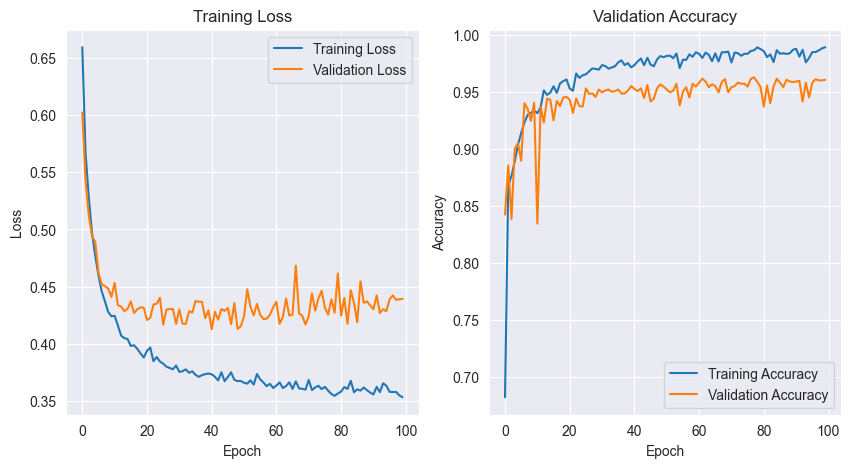

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [11]:
input_shape = (95, 3)
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)
sum(p.numel() for p in model.parameters() if p.requires_grad)

14496

In [ ]:
pred = np.argmax(y_pred.data, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_pred, axis=1))